## Process & group soil files

After doing a lot of digging around, my conclusion is that there are not a lot of good resources out there to do this in Python. Some pointers include: 
- Plotly: https://plotly.com/python/ternary-plots/
- Plotly ternary plot polygon info: https://chart-studio.plotly.com/~plotly2_demo/455/#code
- soil texture wizerd with R: https://cran.r-project.org/web/packages/soiltexture/vignettes/soiltexture_vignette.pdf
    - this package seems very comprehensive, but works with R
- python-ternary with Python: https://github.com/marcharper/python-ternary
- USDA soil texture calculator: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_054167
- soil texture lookup table: https://www.researchgate.net/post/Is-there-anyone-who-knows-how-we-can-made-a-soil-texture-map-from-three-layer-of-clay-loam-and-sand-in-ARCmap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import seaborn as sns
import plotly.express as px

from soilquery import soilquery

In [3]:
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                         index_col=0, dtype={'site':str})
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered.csv', 
                            index_col=0, dtype={'site':str})
sites = set(df_siteyears.site)
df_sites = df_summary[df_summary.site.isin(sites)]
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148
10,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572
11,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471


In [8]:
df_soils = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/soiltexture.csv', 
                       index_col=0, dtype={'site': str, 'sgroup': str})
df_soils.head()

,cokey,chkey,prcent,slope_r,slope,hzname,depth,awc,clay,silt,...,OM,dbthirdbar,th33,bd,site,lat,lon,depth_category,texture,sgroup
0,20681154,60804747,60.0,1.0,2,H1,0.0,0.07,7.0,6.6,...,1.50,1.55,16.6,-0.1505,722590,32.117,-81.20,0.0,sand,1
1,20681154,60804748,60.0,1.0,2,H2,71.0,0.11,25.0,18.0,...,0.25,1.63,24.9,-0.2327,722590,32.117,-81.20,100.0,sandy clay loam,1
2,20681154,60804749,60.0,1.0,2,H3,150.0,0.11,27.5,17.4,...,0.25,1.63,25.9,-0.2427,722590,32.117,-81.20,150.0,sandy clay loam,1
3,20646330,60671139,85.0,3.0,5,A,0.0,0.04,1.5,4.9,...,0.53,1.45,5.2,-0.0375,725118,30.400,-84.35,0.0,sand,1
4,20646330,60671138,85.0,3.0,5,C,18.0,0.04,1.0,1.1,...,0.05,1.45,4.0,-0.0255,725118,30.400,-84.35,50.0,sand,1


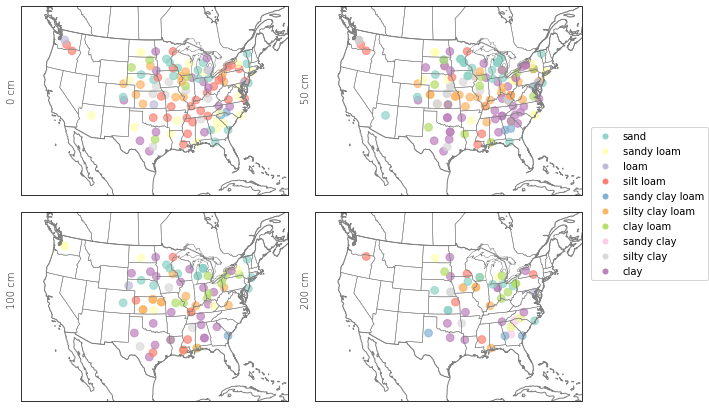

In [6]:
# set up legend 
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
          '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
texts = ['sand', 'sandy loam', 'loam', 'silt loam', 'sandy clay loam',
         'silty clay loam', 'clay loam', 'sandy clay', 'silty clay', 'clay']


patches = [plt.plot([],[], marker='o', ms=5, ls='', 
                    color=colors[i], 
                    label=texts[i])[0] for i in range(len(texts)) ]
plt.close()

# plot
pmins = [-1, 0, 50, 100]
pmaxs = [0, 50, 100, 200]
colors = {'sand':'#8dd3c7', 'sandy loam':'#ffffb3', 'loam':'#bebada', 'silt loam':'#fb8072', 'sandy clay loam':'#80b1d3',
          'silty clay loam':'#fdb462', 'clay loam':'#b3de69', 'sandy clay':'#fccde5', 'silty clay':'#d9d9d9', 'clay':'#bc80bd'}

fig = plt.figure(figsize=(10,10))

for i in np.arange(1,5):
    ax = fig.add_subplot(2,2,i, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    
    df_s = df_soils[(df_soils.depth > pmins[i-1]) & (df_soils.depth <= pmaxs[i-1])]

    scatter = ax.scatter(df_s.lon, df_s.lat, transform=ccrs.PlateCarree(), s=60,
                         c=df_s.texture.map(colors), alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.text(-0.05, 0.5, str(pmaxs[i-1]) + ' cm', 
            rotation='vertical', fontweight='light', transform=ax.transAxes)

fig.legend(handles=patches, loc='right', borderaxespad=0.2)
fig.subplots_adjust(left=0.05, bottom=0, right=0.83, top=1, wspace=0.1, hspace=-0.6)

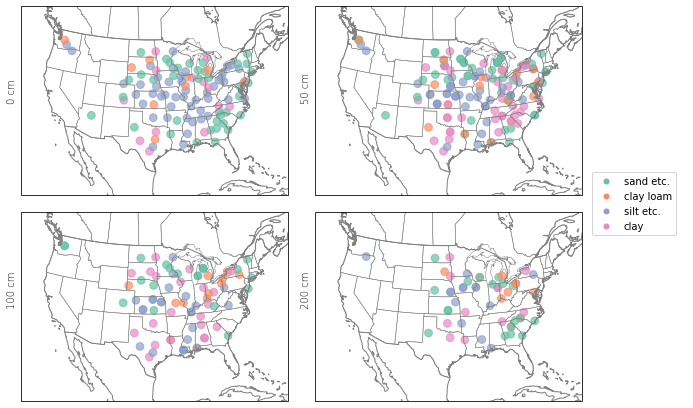

In [9]:
# set up legend 
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
texts = ['sand etc.', 'clay loam', 'silt etc.', 'clay']

patches = [plt.plot([],[], marker='o', ms=5, ls='', 
                    color=colors[i], 
                    label=texts[i])[0] for i in range(len(texts)) ]
plt.close()

# plot
pmins = [-1, 0, 50, 100]
pmaxs = [0, 50, 100, 200]
colors = {'1':'#66c2a5', '2':'#fc8d62', '3':'#8da0cb', '4':'#e78ac3'}
texts = ['group1', 'group2', 'group3', 'group4']

fig = plt.figure(figsize=(10,10))

for i in np.arange(1,5):
    ax = fig.add_subplot(2,2,i, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    
    df_s = df_soils[(df_soils.depth > pmins[i-1]) & (df_soils.depth <= pmaxs[i-1])]

    scatter = ax.scatter(df_s.lon, df_s.lat, transform=ccrs.PlateCarree(), s=60,
                         c=df_s.sgroup.map(colors), alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.text(-0.05, 0.5, str(pmaxs[i-1]) + ' cm', 
            rotation='vertical', fontweight='light', transform=ax.transAxes)

fig.legend(handles=patches, loc='right', borderaxespad=1.8)
fig.subplots_adjust(left=0.05, bottom=0, right=0.83, top=1, wspace=0.1, hspace=-0.6)

### Add soil category into sites info:
Questions: 
1. What to do with sites that don't have soil query info? <br/>
    - Total of 22 sites that don't have soil info
    - Adopt soil texture of nearest site?
    - Average soil texture if the nearest 3 sites?
2. What to do with depth?
    - Can I just assume that soil properties are all the same at different depth?
    - And maybe just assign uniform depth to all locaitons? 
    - 5 layers: 0, 0-50, 50-100, 100-150, 150+

#### Assign soil class for each location after averaging soil composition across all depth:

In [113]:
# average soil info across depth for each site
df_soils_sites = df_soils.groupby(['site']).mean()

# set up boundaries for 10 soil classes & 4 soil groups
sand_min = [80,50,30,0,50,0,20,50,0,0]
sand_max = [100,80,50,50,80,30,50,70,20,50]
silt_min = [0,0,30,50,0,50,20,0,50,0]
silt_max = [20,50,50,100,30,80,50,20,70,50]
clay_min = [0,0,0,0,20,20,20,30,30,30]
clay_max = [20,20,20,20,30,30,30,50,50,100]
texture_class = ['sand', 'sandy loam', 'loam', 'silt loam', 'sandy clay loam', 
                 'silty clay loam', 'clay loam', 'sandy clay', 'silty clay', 'clay']
sgroup = [1, 1, 2, 3, 1, 3, 2, 1, 3, 4]

# create texture table
df_texture = pd.DataFrame({'sand_min': sand_min,
                           'sand_max': sand_max,
                           'silt_min': silt_min, 
                           'silt_max': silt_max,
                           'clay_min': clay_min, 
                           'clay_max': clay_max,
                           'texture': texture_class,
                           'sgroup': sgroup})

# assign soil group for each location based on averaged soil profile across depth
sgroups = []
for i in list(df_soils_sites.index):
    sand = df_soils_sites.loc[i,'sand']
    silt = df_soils_sites.loc[i,'silt']
    clay = df_soils_sites.loc[i,'clay']

    sgroup = df_texture[
        (sand > df_texture.sand_min) & (sand <= df_texture.sand_max) & 
        (silt > df_texture.silt_min) & (silt <= df_texture.silt_max) & 
        (clay > df_texture.clay_min) & (clay <= df_texture.clay_max)].sgroup.values[0]
    sgroups.append(sgroup)

df_soils_sites['sgroup'] = sgroups
print(df_soils_sites.shape)
df_soils_sites.head()

(108, 18)


,cokey,chkey,prcent,slope_r,slope,depth,awc,clay,silt,sand,OM,dbthirdbar,th33,bd,lat,lon,depth_category,sgroup
site,,,,,,,,,,,,,,,,,,
722070,19699452.0,57590014.5,30.0,45.0,80.0,27.250000,0.055000,12.250000,32.250000,55.500000,1.1875,1.430000,12.425000,-0.109950,37.583,-83.317,62.500000,1
722140,20289055.0,59531495.0,55.0,4.0,5.0,49.000000,0.106667,21.833333,11.800000,66.366667,0.2500,1.510000,21.566667,-0.200567,32.517,-84.950,66.666667,1
722170,20460021.0,60077457.5,90.0,1.0,2.0,9.000000,0.220000,17.000000,60.500000,22.500000,1.2500,1.280000,25.900000,-0.246200,42.383,-96.383,25.000000,3
722180,19907636.0,58301570.0,55.0,30.0,50.0,0.000000,0.140000,17.000000,17.900000,65.100000,0.2500,1.480000,16.700000,-0.152200,35.433,-82.533,0.000000,1
722230,20438620.0,60006147.0,40.0,7.0,10.0,49.666667,0.073333,3.666667,4.333333,92.000000,0.5000,1.526667,9.766667,-0.082400,41.700,-86.333,66.666667,1


#### Address sites with no soil info:

In [132]:
df_sites_nosoil = df_sites[~df_sites.site.isin(set(df_soils.site))]
print('sites with no soil info:', df_sites_nosoil.shape[0])

sites with no soil info: 22


In [130]:
df_sites = df_sites.merge(df_soils_sites.sgroup, how='left', left_on='site', right_on=df_soils_sites.sgroup.index)
# **create another df that's not named df_sites or just stick to df_sites and overwrite it?

In [133]:
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri,sgroup
0,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904,1.0
1,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219,NaN
2,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148,1.0
3,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572,3.0
4,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471,1.0


### Calcualte sand/silt/clay content for each soil group:

In [42]:
df_soils.groupby(['sgroup']).mean()[['clay','silt','sand','OM','dbthirdbar','th33']]

,clay,silt,sand,OM,dbthirdbar,th33
sgroup,,,,,,
1,9.357983,13.052941,77.589076,1.079664,1.482521,14.578151
2,24.331915,39.504255,36.163830,2.454255,1.564894,26.859574
3,23.867424,64.555303,11.577273,3.318333,1.359015,29.485606
4,44.057317,38.873171,17.069512,2.006098,1.398780,33.759756


In [22]:
df_sites

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,2445.923794,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,10052.406880,5.735219
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,9510.127270,13.348148
10,722170,1,MACON MIDDLE GA REGIONAL AP,GA,-5,32.683,-83.650,22,2731.632292,18.039572
11,722180,1,AUGUSTA BUSH FIELD,GA,-5,33.367,-81.967,18,5940.794366,8.403471
...,...,...,...,...,...,...,...,...,...,...
193,727450,1,DULUTH INTERNATIONAL ARPT,MN,-6,46.833,-92.217,24,3366.989685,0.872252
195,727530,1,FARGO HECTOR INTERNATIONAL AP,ND,-6,46.933,-96.817,25,28514.194400,0.610868
196,727640,1,BISMARCK MUNICIPAL ARPT [ISIS],ND,-7,46.767,-100.750,22,4977.641160,1.393164
204,727810,1,YAKIMA AIR TERMINAL,WA,-8,46.567,-120.550,25,5592.764148,45.433900


### Closer look at soil profile for each site:
- Looking at results, it probably makes sense to just have all depths be the same soil category?
- Also, maybe the deeper soil layers are not as important?
- They're probably still important for water transport, but how deep do maize roots get?

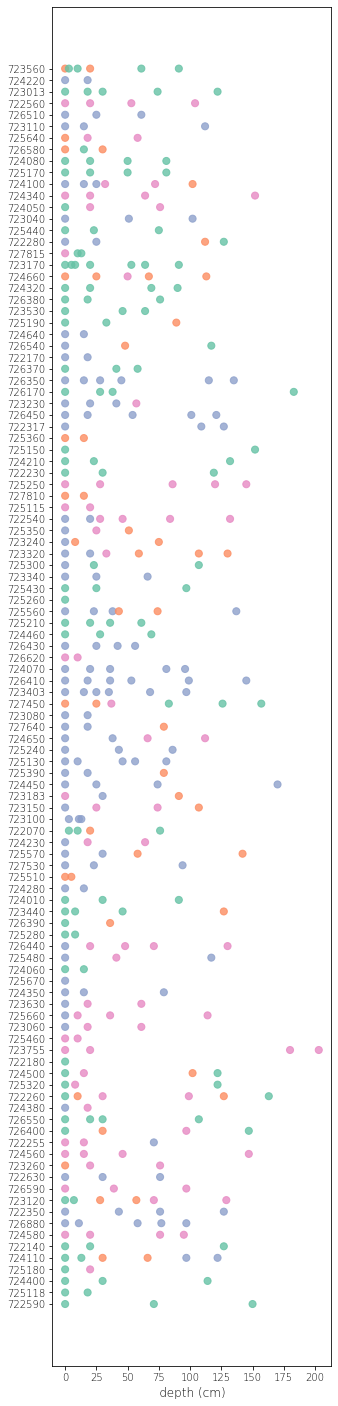

In [5]:
colors = {1:'#66c2a5', 2:'#fc8d62', 3:'#8da0cb', 4:'#e78ac3'}

fig, ax = plt.subplots(figsize=(5,25))
ax.scatter(df_soils.depth, df_soils.site, 
           c=df_soils.sgroup.map(colors), alpha=0.8, s=50)
ax.set_xlabel('depth (cm)', fontweight='light', size=12)
plt.xticks(fontweight='light')
plt.yticks(fontweight='light')
plt.show()

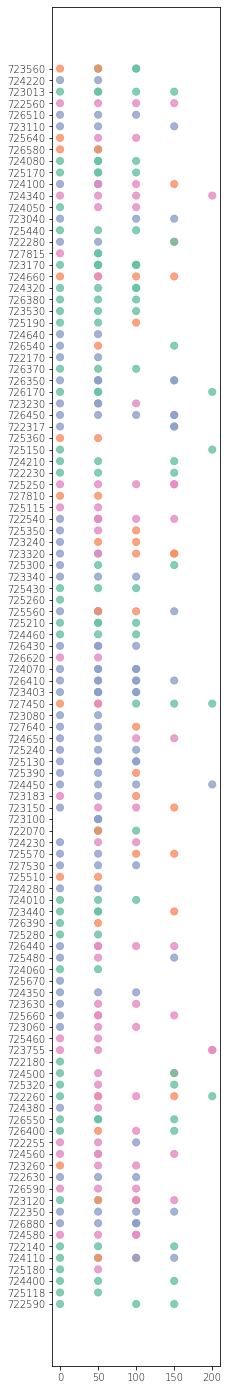

In [6]:
colors = {1:'#66c2a5', 2:'#fc8d62', 3:'#8da0cb', 4:'#e78ac3'}

fig, ax = plt.subplots(figsize=(3,25))
ax.scatter(df_soils.depth_category, df_soils.site, 
           c=df_soils.sgroup.map(colors), alpha=0.8, s=50)
plt.xticks(fontweight='light')
plt.yticks(fontweight='light')
plt.show()